In [8]:
import logging

logging.basicConfig(level=logging.INFO)

In [9]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss

# from pennylane import NesterovMomentumOptimizer
from qcc.qcnn import QCNN

from qcc.ml.data import Data, BinaryData
from qcc.ml.optimize import Optimizer
from qcc.ml.data import ImageTransform, ImageTransform1D
from qcc.experiment import Experiment
from qcc.cnn import CNN

from pathlib import Path
from qcc.file import save_dataframe_as_csv

from qcc.quantum.operation.ansatz import ConvolutionPoolingAnsatz as Ansatz
# from qcc.quantum.operation.ansatz import BaselineAnsatz as Ansatz

# from qcc.quantum.operation.ansatz.basic import BasicFiltering6
from qcc.quantum.operation.fully_connected import FullyConnected

In [10]:
# Meta parameters
name = "test"
path = Path(f"results/{name}")
num_trials = 1
silent = False
is_quantum = False

# Ansatz parameters
dims = (16, 16)
num_layers = 1
options = {
    # "U_filter": BasicFiltering6,
    # "U_fully_connected": None,
    # "pooling": True,
    # "filter_shape": (2, 2, 2)
}

In [11]:
# Create model
cls = QCNN if is_quantum else CNN
data = BinaryData(FashionMNIST, ImageTransform.is_quantum(dims, is_quantum), batch_size=(4, 1000))
# optimizer = Optimizer(SGD, lr=0.01, momentum=0.9, nesterov=True)
optimizer = Optimizer(Adam)
loss = CrossEntropyLoss()
epoch = 1
model = cls.with_logging(data, optimizer, loss, epoch=epoch)

# Log circuit ID
model.logger.info(f"Circuit ID: {name}")

# Save circuit drawing
if is_quantum:
    model.ansatz = Ansatz.from_dims(dims, num_layers=num_layers, **options)
    filename = path / f"{name}_circuit.png"
    model.ansatz.draw(filename=filename, decompose=True)

2023-07-27 02:08:29,991: (cnn) Circuit ID: test


In [12]:
results_schema = ["accuracy", "training_time", "testing_time"]
experiment = Experiment(model, num_trials, results_schema=results_schema)

fn = experiment.callable_wrapper(
    *(Ansatz,) if is_quantum else (),
    dims,
    num_layers,
    silent=False,
    **options if is_quantum else {},
)
results = experiment(fn=fn, filename=path / name, merge=False)

2023-07-27 02:08:30,031: (cnn_trial_0) Number of Parameters: 518


2023-07-27 02:08:35,371: (cnn_trial_0) Training took 5.339 sec
2023-07-27 02:08:35,511: (cnn_trial_0) Testing took: 0.13911 sec
2023-07-27 02:08:35,511: (cnn_trial_0) Accuracy: 50.00000%


In [13]:
# Save and print accuracy results
acc = results["accuracy"]
print(acc.median(), acc.mean(), acc.std())

0.5 0.5 0.0


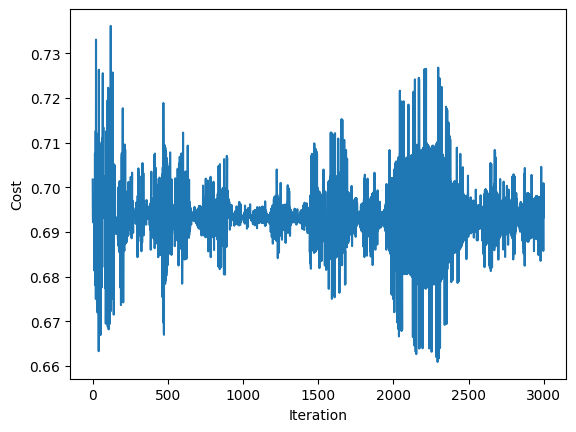

In [14]:
# Save aggregated loss history figure
(fig,) = experiment.draw(path / f"{name}.png")